In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.interpolate import interp1d
from tqdm.notebook import tqdm
import time
import itertools
import os
from pathlib import Path
import pickle
import proplot as pplt

figwidth=3.25
figheight=figwidth*3/4
figwidth_2col=7

# Load in data

Data is taken from the following synthetic data sets published by [Dubarry and Beck](https://shibboleth.columbia.edu/idp/profile/SAML2/Redirect/SSO?execution=e1s1&_eventId_proceed=1):

- [Gr/LFP](https://data.mendeley.com/datasets/bs2j56pn7y/1)
- [Gr/NCA](https://data.mendeley.com/datasets/2h8cpszy26/1)
- [Gr/NMC](https://data.mendeley.com/datasets/pb5xpv8z5r/1)

Since the data is large and provided in multiple files, all the files for each dataset are stored in a directory named by the cathode material of the cell.

In [2]:
def assemble_cap_matrix(material,matfilename):
    start = time.time()
    print(f'loading {material} data')
    
    rawmat = loadmat(os.getcwd() + f'/{material}/{matfilename}_1.mat')
    
    pathinfo = pd.DataFrame(rawmat['pathinfo'],columns = ['LLI','LAMPE','LAMNE','Capacity_Loss'])/100
    values = list(rawmat['Cell_info'][0])
    keys = ['Positive electrode','Negative electrode','LR','OFS','Resistance adjustment',
        '2nd positive electrode if blended electrode','2nd negative electrode if blended electrode',
        '% of PE1', '% of NE1']
    cellinfo = dict(zip(keys, values))
    Qnorm = rawmat['Qnorm'].reshape(len(rawmat['Qnorm']))
    Vrange = np.array([rawmat['Vnorm'].min(),rawmat['Vnorm'].max()])
    V_discrete = np.arange(Vrange[0],Vrange[1],1/1000)

    f = interp1d(rawmat['volt_part1'].T[0],Qnorm,bounds_error=False,fill_value=(0,Qnorm.max()))
    Q0 = f(V_discrete)
    
    cookedvolt = rawmat['volt_part1']
    
    for i in [2,3]:
        rawmat = loadmat(os.getcwd() + f'/{material}/{matfilename}_{i}.mat')
        cookedvolt = np.concatenate((cookedvolt,rawmat['volt_part'+str(i)]),axis=1)
        
    duration = time.time() - start
    print(f'loading {material} data took {int(duration)} s')
    
    
        
    return {'cellinfo':cellinfo,'pathinfo':pathinfo,'volt':cookedvolt,'Qnorm':Qnorm,'V_discrete':V_discrete,'Q0':Q0}

In [3]:
filename_dict = {'LFP':'Gr-LFP_5000paths','NCA':'Gr-NCA_Co33_cha','NMC':'Gr-NMC811_Co25_cha'}
materials = list(filename_dict.keys())

all_data = {}
for material,material_filename in filename_dict.items():
    all_data[material] = assemble_cap_matrix(material,material_filename)


loading LFP data
loading LFP data took 19 s
loading NCA data


/Users/karthikmayilvahanan/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:684: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


loading NCA data took 24 s
loading NMC data
loading NMC data took 19 s


Fuction for assigning classes from continuous data for classification. See Equations 1-5 in paper.

In [4]:
def make_groups(y,material):
    LRinit = all_data[material]['cellinfo']['LR'][0][0]
    OFSinit = all_data[material]['cellinfo']['OFS'][0][0]/100

    y['LR'] = LRinit*(1-y['LAMNE'])/(1-y['LAMPE'])
    y['OFS'] = OFSinit + y['LLI'] - y['LR']*y['LAMPE']/LRinit
    y['PT'] = 1 - (1-y['LAMPE'])*(1-OFSinit-y['LLI'])/(LRinit - y['LAMPE'])
    
    y['group'] = np.zeros(len(y))
    y.loc[y.loc[y.OFS<0].index,'group'] += 1
    y.loc[y.loc[y.LAMNE<y.PT].index,'group'] += 2

    return y

# Split training and testing sets

Create a grid of desired points, and find the nearest points using KDTree

In [5]:
from scipy.spatial import KDTree
def closest_sims(y,pathinfo):
    kdtree=KDTree(pathinfo.values[:,:3])
    dist,points=kdtree.query(y.values[:,:3],1)
    return pathinfo.loc[points,:]

In [6]:
for material,mat_data in all_data.items():
    print(f'making sets for {material}')
    pathinfo = mat_data['pathinfo']
    
    start = time.time()
    iteration_lists = []
    for i in range(3):
        iteration_lists.append(list(np.arange(0,0.8,0.05)))

    grid_samples_train = list(itertools.product(iteration_lists[0],iteration_lists[1],iteration_lists[2]))
    y_train = pd.DataFrame(grid_samples_train,columns=pathinfo.columns[:3])

    mat_data['y_train'] = make_groups(closest_sims(y_train,pathinfo),material)
    print(f'   making train set took {int(time.time()-start)}s')
    
    start = time.time()
    iteration_lists = []
    for i in range(3):
        iteration_lists.append(list(np.arange(0,0.8,0.025)))

    grid_samples_train = list(itertools.product(iteration_lists[0],iteration_lists[1],iteration_lists[2]))
    y_test = pd.DataFrame(grid_samples_train,columns=pathinfo.columns[:3])

    mat_data['y_test'] = make_groups(closest_sims(y_test,pathinfo),material)
    print(f'   making test set took {int(time.time()-start)}s')
    
    

making sets for LFP
   making train set took 4s
   making test set took 8s
making sets for NCA
   making train set took 3s
   making test set took 8s
making sets for NMC
   making train set took 3s
   making test set took 9s


# Featurization

1. Map all curves to the voltage range, interpolating capacities as necessary.
2. Choose n_features evenly spaced values from each curve to be representative features of that curve.
3. rescale the value of each feature across the training data based on the minimum and maximum value of that feature across the N_train training points

In [9]:
n_features = 20

In [10]:
def scrub_nans(profile,Qnorm):
    Qnorm_cut = Qnorm[~np.isnan(profile)]
    profile_cut = profile[~np.isnan(profile)]
    return Qnorm_cut, profile_cut

def calc_IC(Q,V):
    return V[1:] - np.diff(V),np.diff(Q)/np.diff(V)

def calc_DV(Q,V):
    return Q[1:] - np.diff(V), np.diff(V)/np.diff(Q)

In [8]:
for material,mat_data in all_data.items():
    
    y_train = mat_data['y_train']
    y_test = mat_data['y_test']

    print(f'processing {material} profiles')
    pathinfo = mat_data['pathinfo']
    Qnorm = mat_data['Qnorm']
    V_discrete = mat_data['V_discrete']
    Q0 = mat_data['Q0']
    deltaQs = np.empty((len(pathinfo),len(V_discrete)))* np.nan
    ICs = np.empty((len(pathinfo),len(V_discrete)-1))* np.nan
    DVs = np.empty((len(pathinfo),len(Qnorm)-1))* np.nan

    start = time.time()
    for i in y_train.index:
        Qnorm_cut,profile_cut = scrub_nans(mat_data['volt'].T[i],Qnorm)
        f = interp1d(profile_cut,Qnorm_cut,bounds_error=False,fill_value=(0,Qnorm_cut.max()))
        deltaQs[i,:] = f(V_discrete) - Q0
        ICs[i,:] = calc_IC(f(V_discrete),V_discrete)[1]
        DVs[i,:] = calc_DV(Qnorm,mat_data['volt'].T[i])[1]
    print(f'   processing training set took {int(time.time()-start)}s')
    
    start = time.time()
    for i in y_test.index:
        Qnorm_cut,profile_cut = scrub_nans(mat_data['volt'].T[i],Qnorm)
        f = interp1d(profile_cut,Qnorm_cut,bounds_error=False,fill_value=(0,Qnorm_cut.max()))
        deltaQs[i,:] = f(V_discrete) - Q0
        ICs[i,:] = calc_IC(f(V_discrete),V_discrete)[1]
        DVs[i,:] = calc_DV(Qnorm,mat_data['volt'].T[i])[1]
    print(f'   processing test set 1 took {int(time.time()-start)}s')
    
            
    mat_data['transformed_profiles'] = {'deltaQ':deltaQs,'IC':ICs,'DV':DVs}

processing LFP profiles
   processing training set took 3s
   processing test set 1 took 16s
processing NCA profiles
   processing training set took 3s
   processing test set 1 took 18s
processing NMC profiles
   processing training set took 3s
   processing test set 1 took 18s


In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
for material,mat_data in all_data.items():
    print(f'rescaling {material} profiles')
    
    mat_data['rescaled_profiles'] = {}
    
    for processing,processed_data in mat_data['transformed_profiles'].items():
        
        mat_data['rescaled_profiles'][processing] = {}
        mat_data['rescaled_profiles']['all_features'] = {}
        for ylab,Xlab in zip(['y_train','y_test'],['X_train','X_test']):
            X = processed_data[mat_data[ylab].index]

            if Xlab=='X_train':
                scaler = MinMaxScaler().fit(X)

            X = scaler.transform(X)
            idx = [np.round(np.linspace(0, len(X.T) - 1, n_features)).astype(int)]
            X = X.T[idx,:].T.reshape(len(X),n_features)
            
            mat_data['rescaled_profiles'][processing][Xlab] = np.nan_to_num(X)
            
            
    for Xlab in ['X_train','X_test']:
        all_features = [mat_data['rescaled_profiles'][processing][Xlab] for preprocessing in mat_data['transformed_profiles'].keys()]
        mat_data['rescaled_profiles']['all_features'][Xlab] = np.concatenate(all_features,axis=1)
      

rescaling LFP profiles
rescaling NCA profiles


/Users/karthikmayilvahanan/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/karthikmayilvahanan/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


rescaling NMC profiles


# Define models

Regression models and classification models explored in this study.

In [13]:
from sklearn.linear_model import LinearRegression #,ElasticNetCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

regression_model_dict = {'Linear Regression':MultiOutputRegressor(LinearRegression()),
                         'Random Forrest Regressor': RandomForestRegressor(),
                         'Decision Tree Regressor': DecisionTreeRegressor(),
                        }


In [14]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier #, AdaBoostClassifier
# from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #,QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #,LogisticRegressionCV
# from sklearn.neural_network import MLPClassifier
# from sklearn.gaussian_process import GaussianProcessClassifier


classification_model_dict = {
          'Decision Tree Classifier': DecisionTreeClassifier(),
          'Random Forrest Classifier': RandomForestClassifier(random_state=0),
          'Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=-1),
          'Linear Discriminant Analysis': OneVsRestClassifier(LinearDiscriminantAnalysis(priors=np.array([0.5,0.5])), n_jobs=-1),
          'Logistic Regression': OneVsRestClassifier(LogisticRegression(penalty='none'), n_jobs=-1),
         }

linear_coeff_ovr = ['Logistic Regression','Logistic Regression (Elastic Net)','Linear Discriminant Analysis']
linear_coeff_multioutput = ['Linear Regression','Elastic Net']
tree_based = ['Decision Tree Regressor','Random Forrest Regressor','Decision Tree Classifier','Random Forrest Classifier','AdaBoost Classifier']


# Metrics

In [15]:
from sklearn.metrics import mean_squared_error

def regression_accuracy(model,X,y):
    y_pred = model.predict(X)
    RMSEs = []
    for i,p in enumerate(range(len(y.T))):
        RMSEs.append(np.sqrt(mean_squared_error(y[:,i],y_pred[:,i])))
    return RMSEs

def regression_accuracy2(model,X,y):
    y_pred = model.predict(X)
    MAEs = []
    for i,p in enumerate(range(len(y.T))):
        MAEs.append(MAE(y[:,i],y_pred[:,i]))
    return MAEs

def RMSE(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

def MAPE(y_true,y_pred):
    return np.nanmean(np.abs((y_pred-y_true)/y_true))

def MAE(y_true,y_pred):
    return np.nanmean(np.abs(y_pred-y_true))

def dummify(df):   
        
    df['PElim'] = np.zeros(len(df))
    df['plating'] = np.zeros(len(df))
    
    df.loc[df.OFS <0, 'PElim'] = 1
    df.loc[df.LAMNE > df.PT, 'plating'] = 1
        
    return df

from sklearn.metrics import confusion_matrix

def evaluate_classifier(y,X,model,make_dummy=False,material=None):
    
    y = dummify(y)

    if make_dummy:
        y_pred = pd.DataFrame(model.predict(X),columns=y.columns[:3])
        y_pred = make_groups(y_pred,material)
        y_pred = dummify(y_pred)
    else:
        y_pred = pd.DataFrame(model.predict(X),columns=['PElim','plating'])        

    results_dict = {}
    for i,p in enumerate(['PElim','plating']):
        conf_matrix_flat = confusion_matrix(y.loc[:,p], y_pred.loc[:,p]).reshape(4,)
        results_dict[p] = conf_matrix_flat
            
            
    results = pd.DataFrame(results_dict,index=['TN','FP','FN','TP']).T
    results = add_descriptors(results)
    return results

def evaluate_hamming_loss(results):
    return (results.sum(axis=0)['FP'] + results.sum(axis=0)['FN'])/results.sum(axis=0)['T']

def add_descriptors(confusion_df):
    confusion_df['T'] = confusion_df.sum(axis=1)
    confusion_df['ACC'] = (confusion_df['TP'] + confusion_df['TN'])/confusion_df['T']
    confusion_df['TPR'] = confusion_df['TP']/(confusion_df['TP']+confusion_df['FN'])
    confusion_df['TNR'] = confusion_df['TN']/(confusion_df['TN']+confusion_df['FP'])
    confusion_df['FPR'] = 1-confusion_df['TNR']
    confusion_df['FNR'] = 1-confusion_df['TPR']
    return confusion_df

# ML Experiments Class

To keep track of each ML "experiment" (i.e., different models, training data, etc), create an experiment class where details about the experiment are stored as attributes.

In [16]:
class ML_exp:
    
    def __init__(self,material,preprocessing,model_name,classification):
        self.material = material
        self.preprocessing = preprocessing
        self.model_name = model_name
        self.classification = classification
        self.model = None
        self.results = {'regression':{'Train':{}},'classification':{}}
        self.prediction = {'regression':{},'classification':{}}
        self.prediction_prob = {}
        self.fitted = False
        self.fit_time = None
        self.coef = None
        
    def fit_model(self,X_train,y_train):
        if self.classification:
            mod = classification_model_dict[self.model_name]
            start = time.time()
            self.model = mod.fit(X_train,y_train.loc[:,['PElim','plating']])
            self.fitted=True
            self.results['classification']['Train'] = evaluate_classifier(y_train,X_train,self.model,make_dummy=False)
            self.prediction['classification']['Train'] = self.model.predict(X_train)
            self.prediction_prob['Train'] = self.model.predict_proba(X_train)
            if self.model_name in linear_coeff_ovr:
                self.coef = [self.model.estimators_[j].coef_[0] for j in range(2)]
            elif self.model_name in tree_based[:-1]:
                self.coef = self.model.feature_importances_
            elif self.model_name == 'AdaBoost Classifier':
                self.coef = [self.model.estimators_[j].feature_importances_ for j in range(2)]
            else:
                self.coef = None
            self.fit_time = time.time() - start
            
        else:
            mod = regression_model_dict[self.model_name]
            start = time.time()
            self.model = mod.fit(X_train,y_train.iloc[:,:3])
            self.fitted=True
            self.results['regression']['Train']['RMSE'] = regression_accuracy(self.model,X_train,y_train.values[:,:3])
            self.results['regression']['Train']['MAE'] = regression_accuracy2(self.model,X_train,y_train.values[:,:3])
            self.results['classification']['Train'] = evaluate_classifier(y_train,X_train,self.model,make_dummy=True,material=self.material)
            self.prediction['regression']['Train'] = self.model.predict(X_train)
            self.prediction['classification']['Train'] = dummify(make_groups(pd.DataFrame(self.model.predict(X_train),columns=y_train.columns[:3]),self.material))
            if self.model_name in linear_coeff_multioutput:
                self.coef = [self.model.estimators_[j].coef_ for j in range(3)]
            elif self.model_name in tree_based:
                self.coef = self.model.feature_importances_
            else:
                self.coef = None
            self.fit_time = time.time() - start
            
    def test_model(self,X_test,y_test,lab):
        if not self.fitted:
            raise ValueError('Model has not been fitted!')
            
        if self.classification:
            self.results['classification'][lab] = evaluate_classifier(y_test,X_test,self.model,make_dummy=False)
            self.prediction['classification'][lab] = self.model.predict(X_test)
            self.prediction_prob[lab] = self.model.predict_proba(X_test)
        else:
            self.results['regression'][lab] = {}
            self.results['regression'][lab]['RMSE'] = regression_accuracy(self.model,X_test,y_test.values[:,:3])
            self.results['regression'][lab]['MAE'] = regression_accuracy2(self.model,X_test,y_test.values[:,:3])
            self.results['classification'][lab] = evaluate_classifier(y_test,X_test,self.model,make_dummy=True,material=self.material)
            self.prediction['regression'][lab] = self.model.predict(X_test)
            self.prediction['classification'][lab] = dummify(make_groups(pd.DataFrame(self.model.predict(X_test),columns=y_train.columns[:3]),self.material))


Make a table of all the experiments we want to run

In [17]:
materials = list(all_data.keys())
preprocessing = list(mat_data['rescaled_profiles'].keys())
models = list(regression_model_dict.keys()) + list(classification_model_dict.keys())

ml_experiments = pd.DataFrame(list(itertools.product(materials,preprocessing,models)))
ml_experiments.columns = ['material','preprocessing','model_name']
ml_experiments['classification'] = [True]*len(ml_experiments)
ml_experiments.loc[ml_experiments['model_name'].isin(list(regression_model_dict.keys())),'classification'] = False
ml_experiments['exp_id'] = ml_experiments.index
print(len(ml_experiments))

96


And run all the experiments!

In [18]:
experiments = []
for i in tqdm(ml_experiments.index):
        
    exp_params = dict(ml_experiments.loc[i,['material','preprocessing','model_name','classification']])
    exp = ML_exp(**exp_params)

    X_train = all_data[exp_params['material']]['rescaled_profiles'][exp_params['preprocessing']]['X_train']
    y_train = all_data[exp_params['material']]['y_train']

    exp.fit_model(X_train,y_train)
    
    X_test = all_data[exp_params['material']]['rescaled_profiles'][exp_params['preprocessing']]['X_test']
    y_test = all_data[exp_params['material']]['y_test']

    exp.test_model(X_test,y_test,'Test')

    experiments.append(exp)

# Results

In [20]:
# some plotting stuff

model_label_dict = {'Random Forrest Regressor':'RFR',
                    'Random Forrest Classifier':'RFC',
                    'Support Vector Classifier':'SVC',
                    'Decision Tree Classifier':'DTC',
                    'Decision Tree Regressor':'DTR',
                    'Logistic Regression':'LogReg',
                    'Logistic Regression (Elastic Net)':'LogRegEN',
                    'Linear Regression':'LinReg',
                    'Elastic Net':'EN',
                    'Naive Bayes':'NB',
                    'Linear Discriminant Analysis':'LDA',
                    'Quadratic Discriminant Analysis':'QDA',
                    'Neural Net':'NN',
                    'Gaussian Process Classifier':'GPC',
                    'AdaBoost Classifier':'ABC',
                   }

marker_dict = {'Random Forrest Regressor':'o',
                    'Random Forrest Classifier':'D',
                    'Support Vector Classifier':'d',
                    'Decision Tree Classifier':'^',
                    'Decision Tree Regressor':'>',
                    'Logistic Regression':'<',
                    'Logistic Regression (Elastic Net)':'*',
                    'Linear Regression':'v',
                    'Elastic Net':'P',
                    'Naive Bayes':'h',
                    'Linear Discriminant Analysis':'H',
#                     'Quadratic Discriminant Analysis':'*',
                    'Neural Net':'1',
#                     'Gaussian Process Classifier':'2',
                    'AdaBoost Classifier':'X',
                   }

import seaborn as sns
color_list2 = sns.color_palette("bright")
colors = [color_list2[0],color_list2[3],color_list2[8]]

preprocessing_label_dict = {'deltaQ':'DeltaQ',
                            'IC':'dQ/dV (%/V)',
                            'DV':'dV/dQ (V/%)'};

In [21]:
# helper to search list of experiments based on metadata
def get_ml_exp(material,preprocessing,model_name,classification):
    metadata=locals()
    
    fit_experiments = [e for e in experiments if e.fitted]
    for key,val in metadata.items():
        fit_experiments = [e for e in fit_experiments if getattr(e,key)==val]
        
    return fit_experiments[0]

## Regression

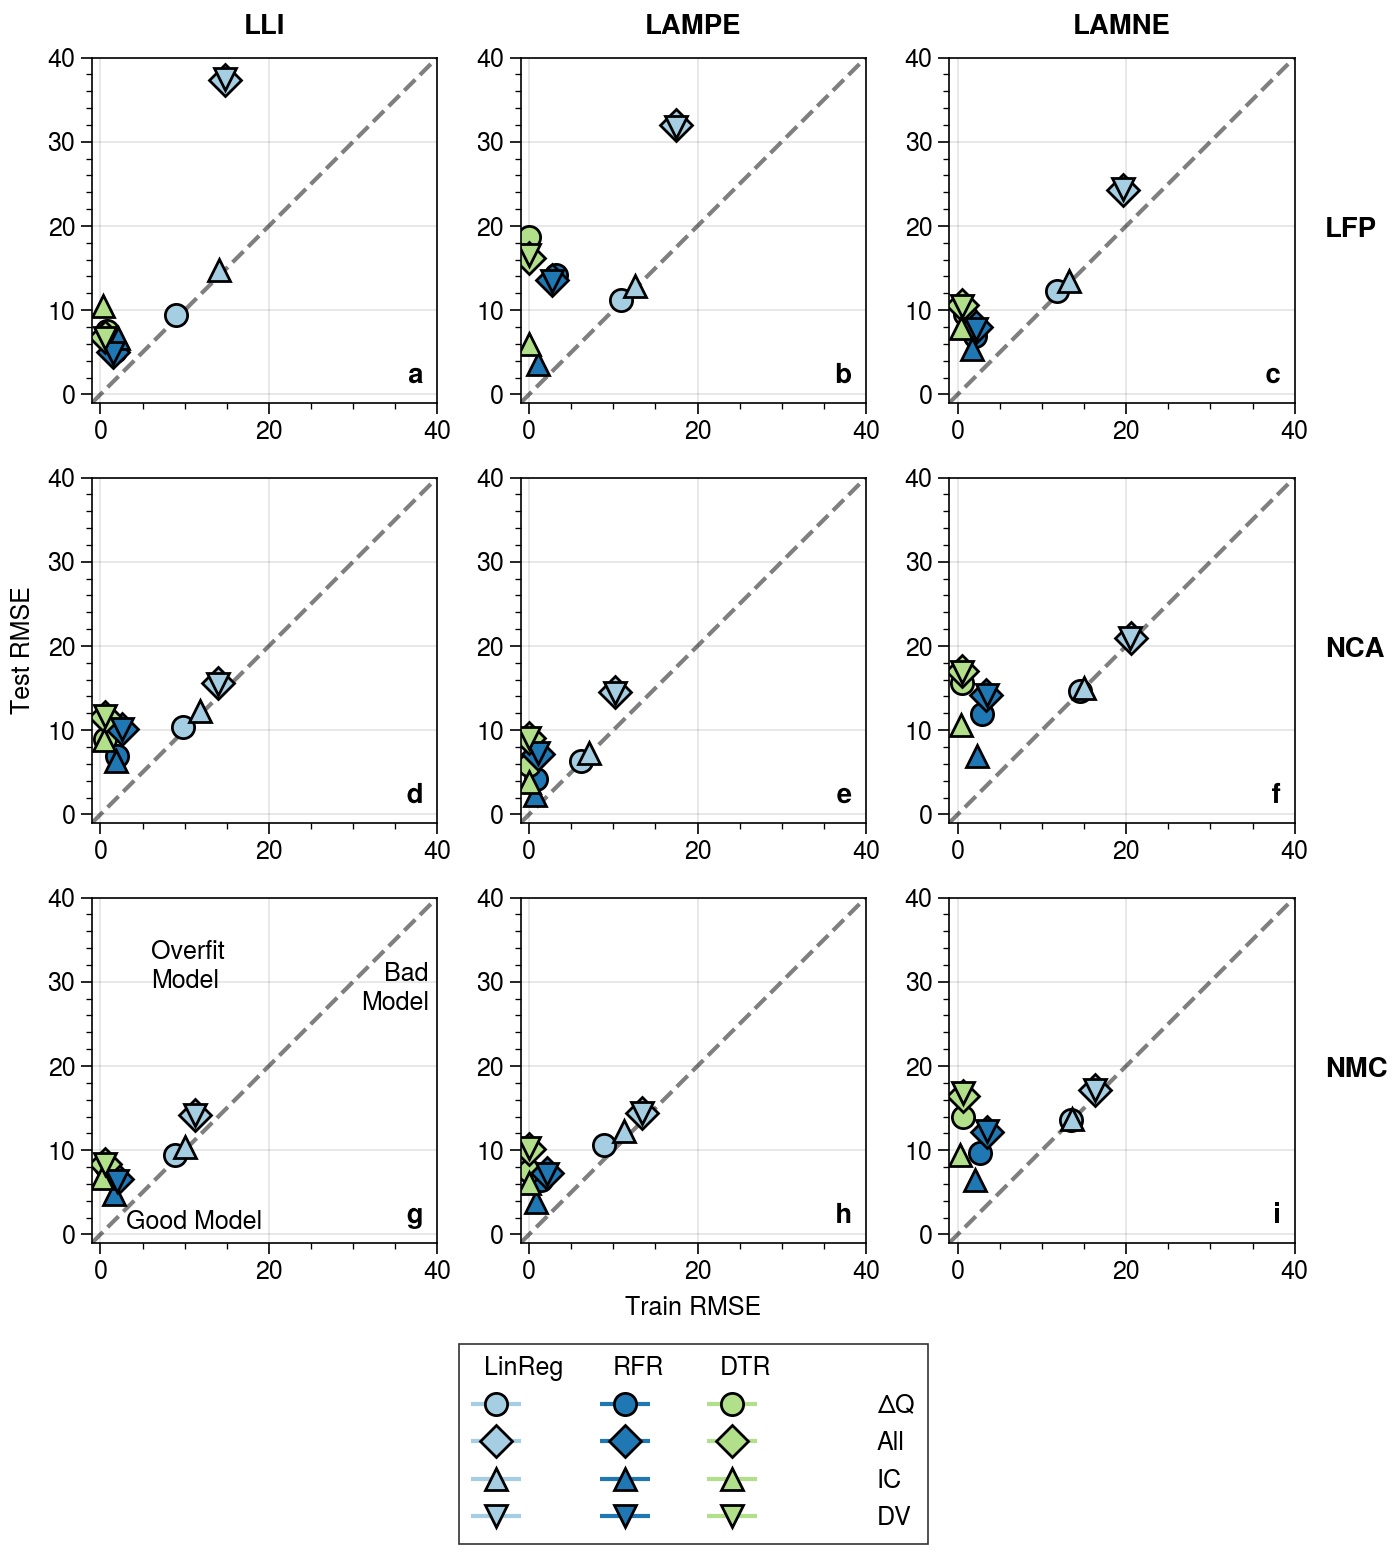

In [24]:
fig,axs = pplt.subplots(ncols=3,nrows=3,sharey=True,sharex=True,width=figwidth_2col,facecolor='w')

for i,material in enumerate(['LFP','NCA','NMC']):
    select_experiments = ml_experiments.loc[ml_experiments.material==material].copy()
    select_experiments = select_experiments.loc[select_experiments.classification==False]
    
    reg_results = [get_ml_exp(**dict(select_experiments.iloc[k,:4])).results['regression']['Test']['RMSE'] for k in range(len(select_experiments))]
    reg_results_df = pd.DataFrame(reg_results,columns=pathinfo.columns[:3])
    
    select_experiments = select_experiments.reset_index(drop=True).merge(reg_results_df, left_index=True, right_index=True)

    reg_results = [get_ml_exp(**dict(select_experiments.iloc[k,:4])).results['regression']['Train']['RMSE'] for k in range(len(select_experiments))]
    reg_results_df = pd.DataFrame(reg_results,columns=pathinfo.columns[:3])
    
    select_experiments = select_experiments.reset_index(drop=True).merge(reg_results_df, left_index=True, right_index=True)

    for j,p in enumerate(pathinfo.columns[:3]):
        ax = axs[i,j]
        ax.plot(np.linspace(-1,40,20),np.linspace(-1,40,20),'--k',alpha=0.5)
        for processing,m in zip(select_experiments['preprocessing'].unique(),['o','D','^','v']):
            processing_df = select_experiments.loc[select_experiments['preprocessing']==processing] #.sort_values(by=['Model Name'])
            colors = mpl.cm.Paired(np.linspace(0,1,12))
            for ii,k in enumerate(processing_df.index):
                if material=='NMC':
                    lab = ' '#model_label_dict[processing_df.loc[i,'Model Name']]
                else:
                    lab = None

                ax.plot(processing_df.loc[k,p+'_y']*100,processing_df.loc[k,p+'_x']*100,
                        c=colors[ii],marker=m,label=lab,mec='k',ms=8)

#         ax.scatter(select_experiments[p+'-Train'],select_experiments[p])
#         ax.plot(np.linspace(0,0.4,10),np.linspace(0,0.4,10),'--k')
    
# axs.format(xlabel='Training RMSE',ylabel='Test RMSE',
#            toplabels=list(pathinfo.columns[:3]),
#            abc=True,abcloc='ul',
#            xlim=(0,0.4),ylim=(0,0.4))
axs.format(abc=True,abcloc='lr',
           rightlabels=['LFP','NCA','NMC'],toplabels=list(pathinfo.columns[:3]),
           xlim=(-1,40),ylim=(-1,40),
           xlabel='Train RMSE',ylabel='Test RMSE')


h, l = ax.get_legend_handles_labels()
ph1 = [mpl.pyplot.plot([],marker="", ls="")[0]]*len(processing_df)
handles1 = ph1 + h
labels1 = [model_label_dict[processing_df.loc[i,'model_name']] for i in processing_df.index] + l

ph2 = [mpl.pyplot.plot([],marker="", ls="")[0]]*5

select_experiments = select_experiments.replace(to_replace=['deltaQ','all_features'],value=[r'$\Delta$Q','All']).copy()
    
processing_conditions = [' '] + list(select_experiments['preprocessing'].unique())
labels2 = [x for y in (labels1[i:i+len(processing_df)] + ['x'] * (i < len(labels1) - len(processing_df)-1) for
     i in range(0, len(labels1), len(processing_df))) for x in y]

handles2 = [x for y in (handles1[i:i+len(processing_df)] + ['x'] * (i < len(handles1) - len(processing_df)-1) for
     i in range(0, len(handles1), len(processing_df))) for x in y]

labels2.append('x')
handles2.append('x')
for pc,ph in zip(processing_conditions,ph2):
#     print(labels2)
    labels2[labels2.index('x')] = pc
    handles2[handles2.index('x')] = ph


leg = fig.legend(handles2, labels2, loc='b',ncol=len(processing_df)+1,frameon=True)

for vpack in leg._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)
        
ax = axs[2,0]
ax.text(6,35,'Overfit\nModel',va='top',ha='left')
ax.text(39,0.17*40/.21,'Bad\nModel',va='top',ha='right')
ax.text(3,0,'Good Model',va='bottom',ha='left')
        
# fig.savefig('figures/overfitting.png',transparent=True,dpi=300)
fig

Above: regression results for all regression 'experiments'

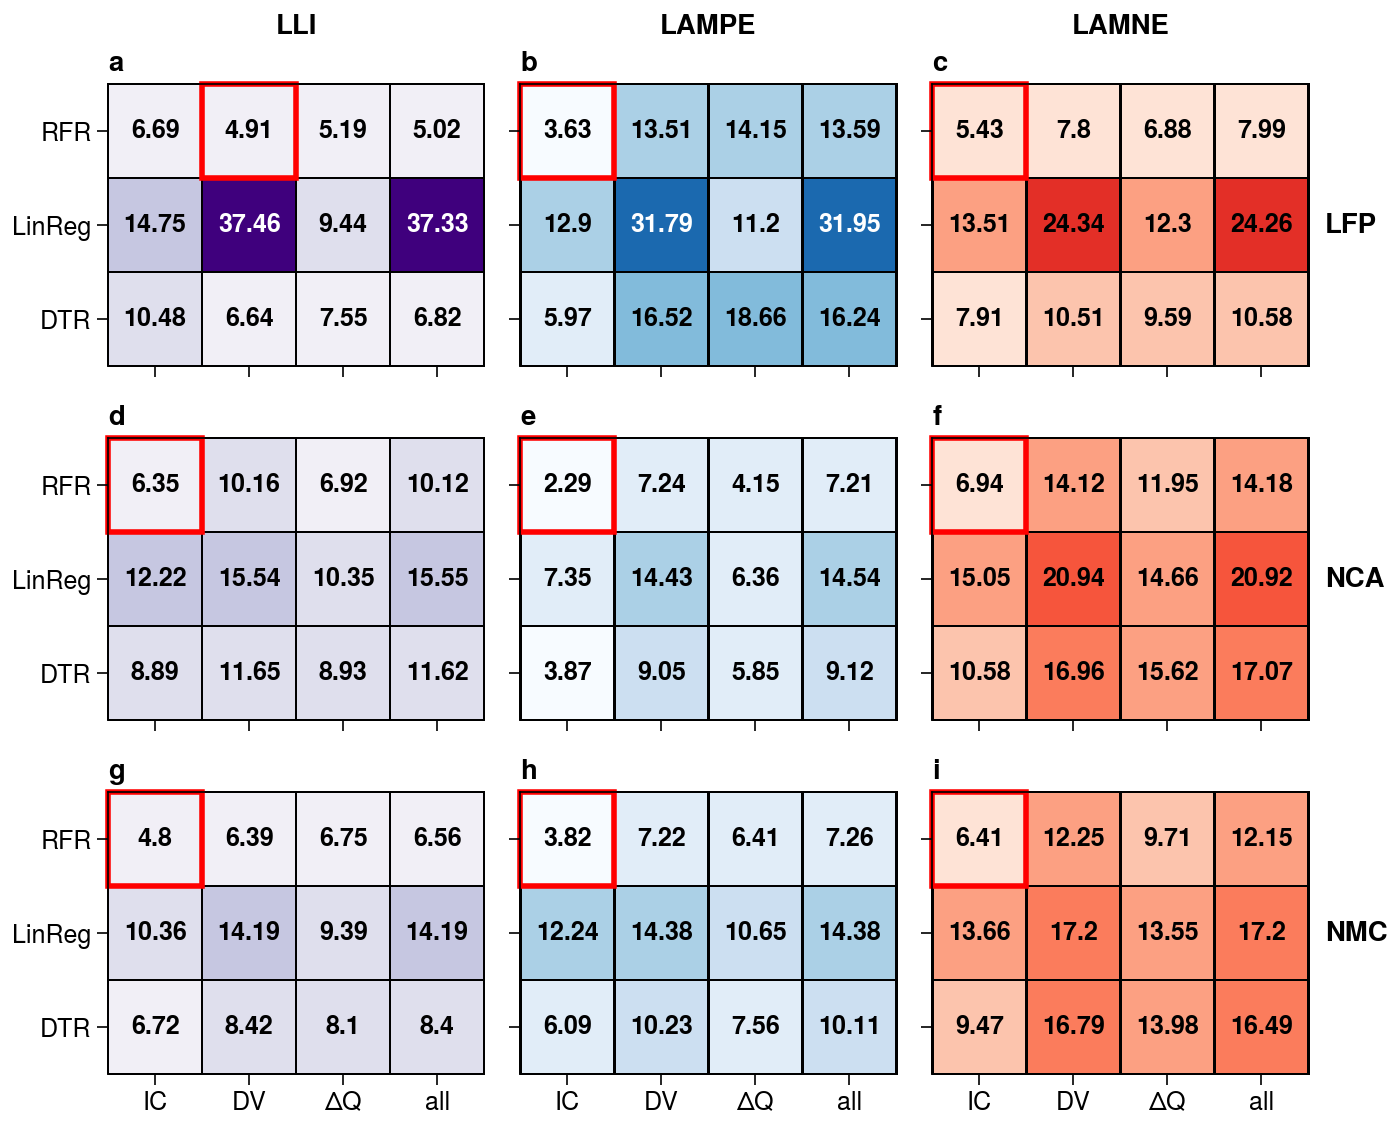

In [25]:
fig, axs = pplt.subplots(nrows=3,ncols=3,width=figwidth_2col,facecolor='w')

for i,material in enumerate(['LFP','NCA','NMC']):
    select_experiments = ml_experiments.loc[ml_experiments.material==material].copy()
    select_experiments = select_experiments.loc[select_experiments.classification==False]
#     select_experiments = select_experiments.reset_index(drop=True).merge(reg_results_df, left_index=True, right_index=True)

    reg_results = [get_ml_exp(**dict(select_experiments.loc[k,['material','preprocessing','model_name','classification']])).results['regression']['Test']['RMSE'] for k in select_experiments.index]
    reg_results_df = pd.DataFrame(reg_results,columns=pathinfo.columns[:3])

#     reg_results_df['Ave'] = reg_results_df.mean(axis=1)
    
    select_experiments = select_experiments.reset_index(drop=True).merge(reg_results_df, left_index=True, right_index=True)


    for j,(p,cmap)in enumerate(zip(pathinfo.columns[:3],['Purples','Blues','Reds'])):
    
        select_experiments_sum = 100*pd.pivot_table(select_experiments,index='model_name',columns='preprocessing',values=p)
        select_experiments_sum.index=['DTR','LinReg','RFR']
        select_experiments_sum = select_experiments_sum[['IC','DV','deltaQ','all_features']]
        select_experiments_sum.columns = ['IC','DV',r'$\Delta$Q','all']

        ax = axs[i,j]
        m = ax.heatmap(
            select_experiments_sum, 
            cmap=cmap, vmin=0, vmax=40, #N=100,
            lw=0.5, edgecolor='k', labels=True, labels_kw={'weight': 'bold'},
            clip_on=False,  # turn off clipping so box edges are not cut in half
        )
        
        minloc=np.where(select_experiments_sum.values == np.min(select_experiments_sum.values))
        
        ax.add_patch(
            mpl.patches.Rectangle(
                (minloc[1][0]-0.5,minloc[0][0]-0.5),width=1,height=1,fill=False,edgecolor='red',clip_on=False,lw=2
            )
        )
    
axs.format(abc=True,abcloc='l',rightlabels=['LFP','NCA','NMC'],toplabels=list(pathinfo.columns[:3]))
# fig.savefig('figures/regression_results_RMSE.png',dpi=300,transparent=True)
fig

## Classification

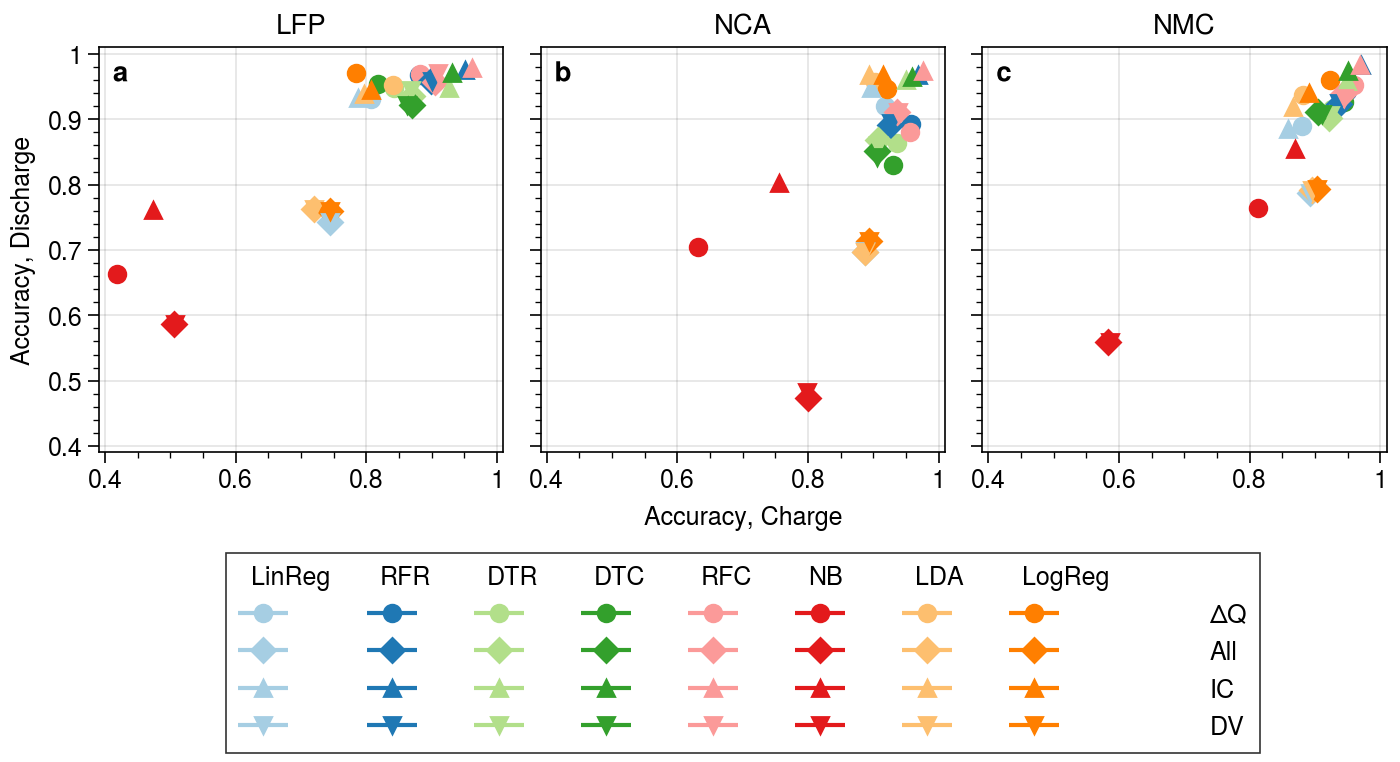

In [27]:
fig,axs = pplt.subplots(nrows=1,ncols=3,width=figwidth_2col,facecolor='w')

for ax,material in zip(fig.axes,['LFP','NCA','NMC']):
    
    lfp_experiments = [e for e in experiments if (e.material == material)]

    lfp_ml_exps = pd.DataFrame([o.__dict__ for o in lfp_experiments])[['material','preprocessing','model_name','classification','fitted','fit_time']]
    lfp_ml_exps['PElim'] = [e.results['classification']['Test'].loc['PElim','ACC'] for e in lfp_experiments]
    lfp_ml_exps['plating'] = [e.results['classification']['Test'].loc['plating','ACC'] for e in lfp_experiments]
    lfp_ml_exps['Ave_acc'] = np.mean([lfp_ml_exps['PElim'].values,lfp_ml_exps['plating'].values],axis=0)
#     display(lfp_ml_exps.sort_values(by=['Ave_acc'],ascending=False).head())

    preprocessing_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
    
    if material=='NMC':
        legendon='full'
    else:
        legendon=False
    
    lfp_ml_exps_plot = lfp_ml_exps.replace(to_replace=['deltaQ','all_features'],value=[r'$\Delta$Q','All']).copy()
    lfp_ml_exps_plot.columns = ['material','Preprocessing','Model Name','classification','fitted','fit_time','PElim','plating','Ave_acc']

    best_classification_model = lfp_ml_exps.loc[lfp_ml_exps.classification].sort_values(by=['Ave_acc'],ascending=False).iloc[0,:]

    # some issue with sns scatterplot and proplot, so do it the long way...
    for processing,m in zip(lfp_ml_exps_plot['Preprocessing'].unique(),['o','D','^','v']):
        processing_df = lfp_ml_exps_plot.loc[lfp_ml_exps_plot['Preprocessing']==processing] #.sort_values(by=['Model Name'])
        colors = mpl.cm.Paired(np.linspace(0,1,12))
        for ii,i in enumerate(processing_df.index):
            if material=='NMC':
                lab = ' '#model_label_dict[processing_df.loc[i,'Model Name']]
            else:
                lab = None
                
            ax.plot(processing_df.loc[i,'PElim'],processing_df.loc[i,'plating'],c=colors[ii],marker=m,label=lab)

    ax.set_xlim(np.min([ax.get_xlim()[0],ax.get_ylim()[0]]),1.01)
    ax.set_ylim(np.min([ax.get_xlim()[0],ax.get_ylim()[0]]),1.01)
    ax.set_title(material)
#     ax.plot(np.linspace(0,ax.get_ylim()[1],10),np.linspace(0,ax.get_ylim()[1],10),'--k')
    
    xx = ax.get_xlim()[0] + 0.03*np.diff(ax.get_xlim())[0]
    yy = ax.get_ylim()[0] + 0.97*np.diff(ax.get_ylim())[0]


# https://stackoverflow.com/questions/31040525/insert-element-in-python-list-after-every-nth-element
h, l = ax.get_legend_handles_labels()
ph1 = [mpl.pyplot.plot([],marker="", ls="")[0]]*len(processing_df)
handles1 = ph1 + h
labels1 = [model_label_dict[processing_df.loc[i,'Model Name']] for i in processing_df.index] + l

ph2 = [mpl.pyplot.plot([],marker="", ls="")[0]]*5

processing_conditions = [' '] + list(lfp_ml_exps_plot['Preprocessing'].unique())
labels2 = [x for y in (labels1[i:i+len(processing_df)] + ['x'] * (i < len(labels1) - len(processing_df)-1) for
     i in range(0, len(labels1), len(processing_df))) for x in y]

handles2 = [x for y in (handles1[i:i+len(processing_df)] + ['x'] * (i < len(handles1) - len(processing_df)-1) for
     i in range(0, len(handles1), len(processing_df))) for x in y]

labels2.append('x')
handles2.append('x')
for pc,ph in zip(processing_conditions,ph2):
#     print(labels2)
    labels2[labels2.index('x')] = pc
    handles2[handles2.index('x')] = ph


leg = fig.legend(handles2, labels2, loc='b',ncol=len(processing_df)+1,frameon=True)

for vpack in leg._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)

axs.format(abc=True,abcloc='ul',xlabel='Accuracy, Charge',ylabel='Accuracy, Discharge')
# fig.savefig('figures/classification_results.png',dpi=300,transparent=True)
# plt.show()
fig

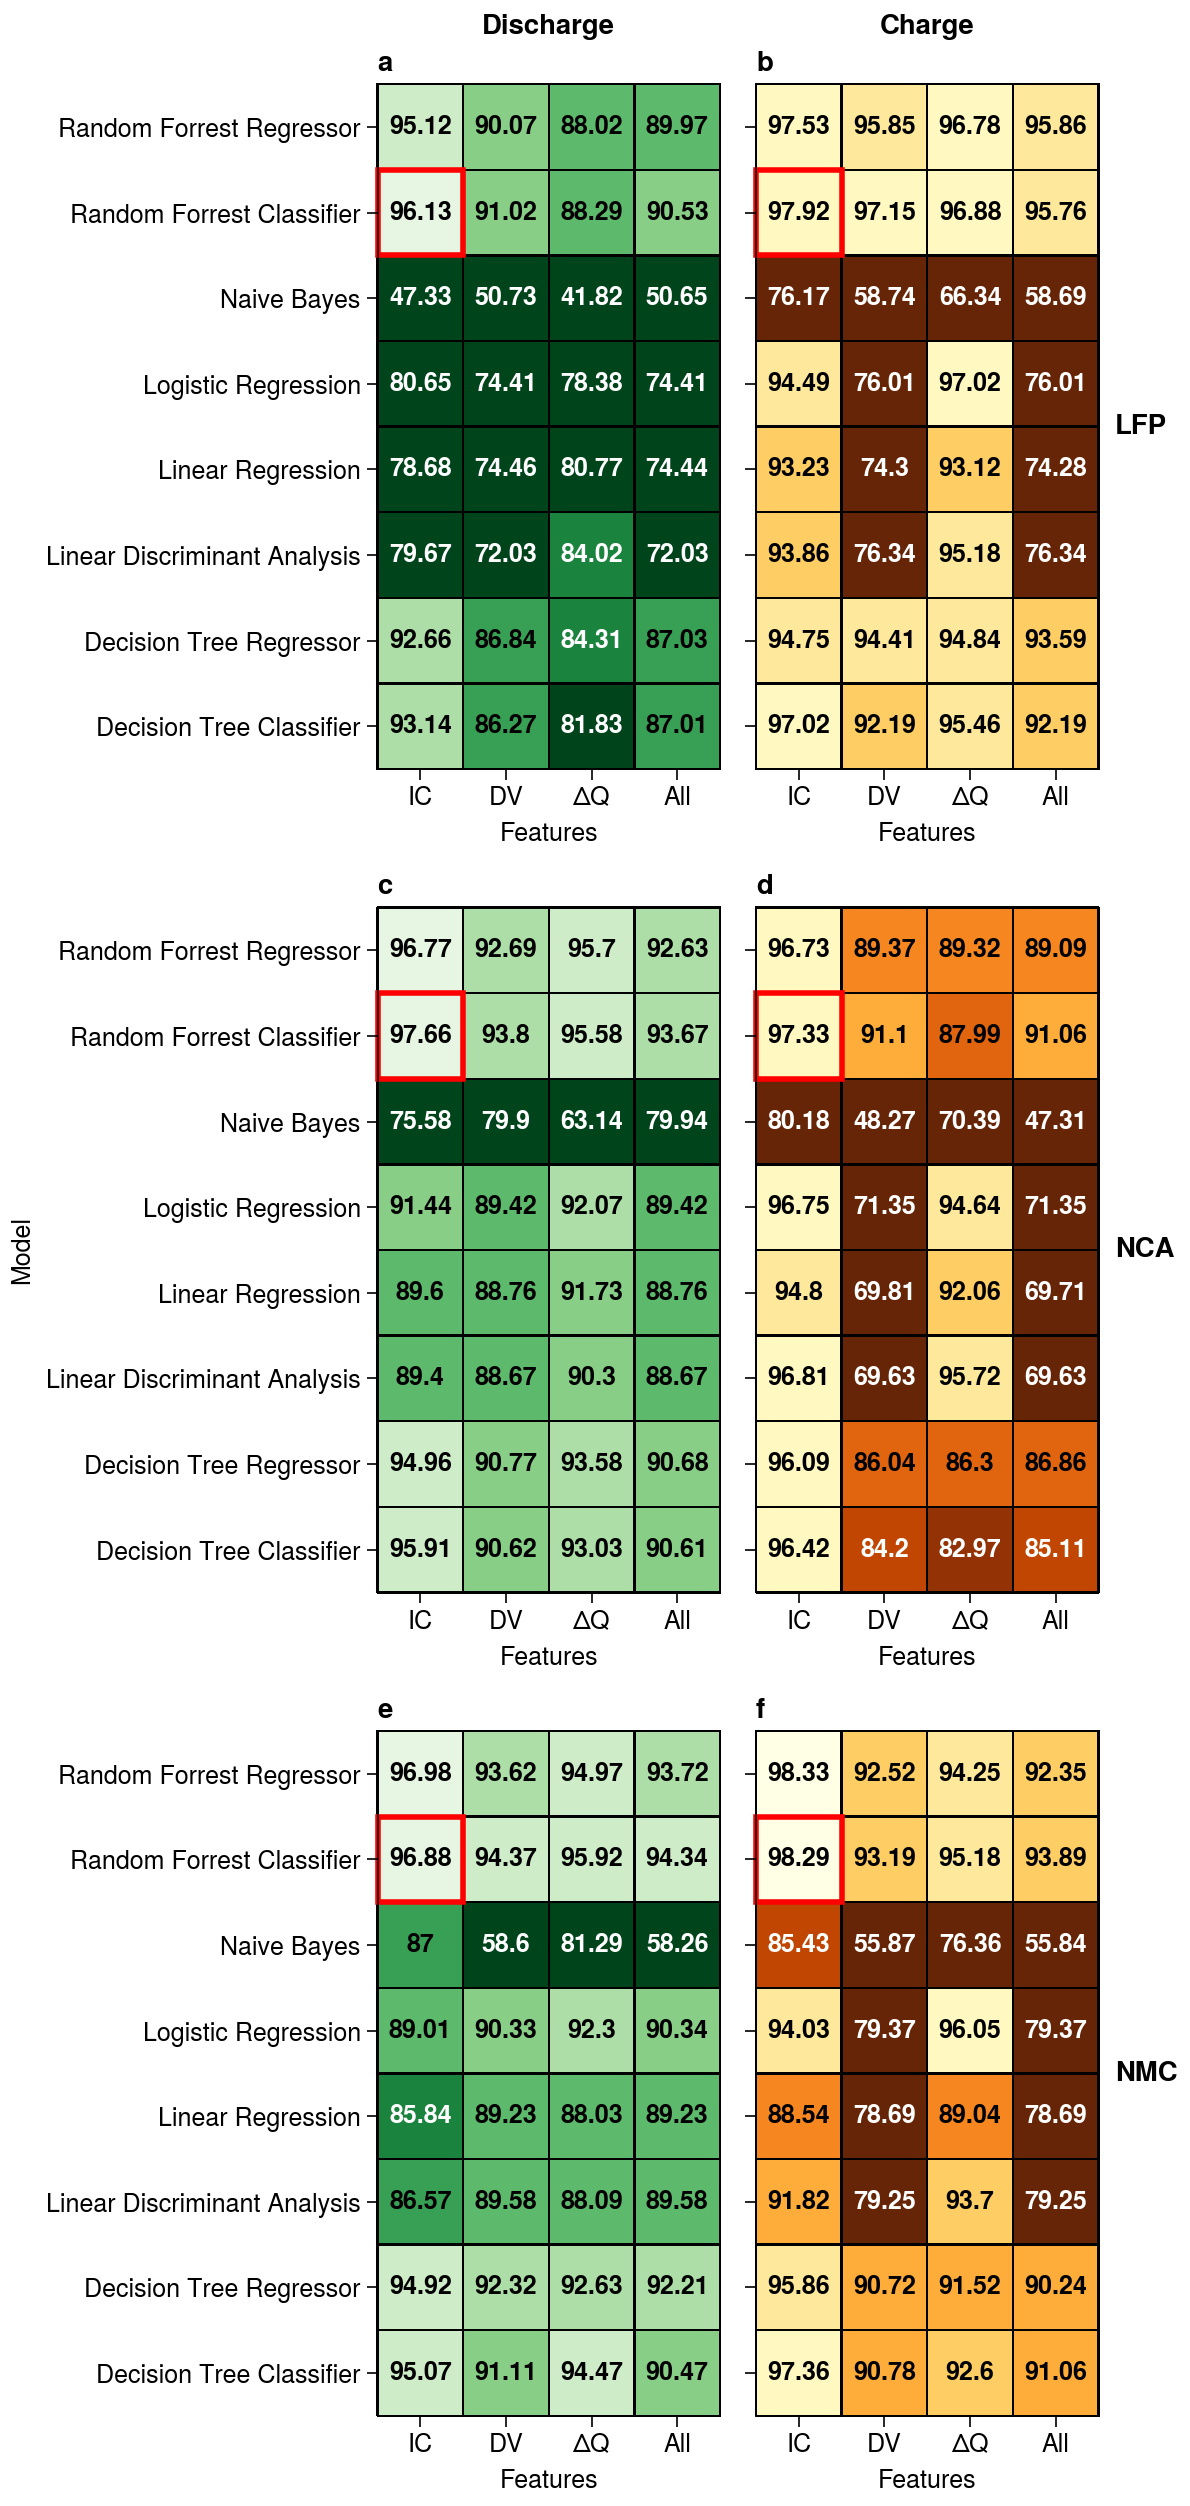

In [32]:
class_experiments = [e for e in experiments]# if e.classification]

class_experiments_df = pd.DataFrame([o.__dict__ for o in class_experiments])[['material','preprocessing','model_name','classification','fitted','fit_time']]
class_experiments_df['DCHG'] = [e.results['classification']['Test'].loc['PElim','ACC'] for e in class_experiments]
class_experiments_df['CHG'] = [e.results['classification']['Test'].loc['plating','ACC'] for e in class_experiments]
class_experiments_df = class_experiments_df.replace(to_replace=['deltaQ','all_features'],value=[r'$\Delta$Q','All']).drop(['classification','fit_time','fitted'],axis=1)
class_experiments_df.iloc[:,-2:] = np.round(class_experiments_df.iloc[:,-2:]*100,2)
class_experiments_df.columns = ['Cell','Features','Model','Discharge','Charge']


fig, axs = pplt.subplots(nrows=3,ncols=2,width=figwidth_2col*0.85,facecolor='w',sharex=False,aspect=0.7)

for i,material in enumerate(['LFP','NCA','NMC']):
    select_experiments = class_experiments_df.loc[class_experiments_df.Cell==material]

    for j,(p,cmap)in enumerate(zip(['Discharge','Charge'],['Greens_r','YlOrBr_r'])):
    
        select_experiments_sum = pd.pivot_table(select_experiments,index='Model',columns='Features',values=p)
        select_experiments_sum = select_experiments_sum[['IC','DV',r'$\Delta$Q','All']]
        ax = axs[i,j]
        m = ax.heatmap(
            select_experiments_sum, 
            cmap=cmap, vmin=80, vmax=100, #N=100,
            lw=0.5, edgecolor='k', labels=True, labels_kw={'weight': 'bold'},
            clip_on=False,  # turn off clipping so box edges are not cut in half
        )
        
        maxloc=np.where(select_experiments_sum.values == np.max(select_experiments_sum.values))
        
        ax.add_patch(
            mpl.patches.Rectangle(
                (0-0.5,6-0.5),width=1,height=1,fill=False,edgecolor='red',clip_on=False,lw=2
            )
        )
    
axs.format(abc=True,abcloc='l',rightlabels=['LFP','NCA','NMC'],toplabels=['Discharge','Charge'])
# fig.savefig('figures/classification_results_table.png',dpi=300,transparent=True)
fig

# Feature Importance

Compare feature importance for linear regression, logistic regression, and random forrest regression to 'Features of Interest' determined by Dubarry et. al. (See Table A3 of [Analysis of Synthetic Voltage vs. Capacity Datasets for Big Data Li-ion Diagnosis and Prognosis](https://www.mdpi.com/1996-1073/14/9/2371)).

In [35]:
LFP_fois = {'minV':[3.35,3.2,3,3,3.42],
            'maxV':[3.4,3.35,3.25,3.25,3.5],
            'metric':['Area','Area','Peak V','Peak I','Area'],
            'mode':['LLILAMNE','LAMNE','LAMPE','LAMPE','plating'],
             'colors':['#b3e2cd','#fdcdac','#cbd5e8','#cbd5e8','#f4cae4']
           }

NCA_fois = {'minV':[4.02,3.6,3.6,4.15,3,3],
            'maxV':[4.05,3.98,3.98,4.225,3.6,3.6],
            'metric':['Area','Valley V','Valley I','Area','Peak V','Peak I'],
            'mode':['LAMPE','LLI','LLI','LAMPELAMNEplating','LLILAMPE','LLILAMPE'],
            'colors':['#b3e2cd','#fdcdac','#fdcdac','#cbd5e8','#f4cae4','#f4cae4']
           }

NMC_fois = {'minV':[4.02,3.6,3.6,4.15,3,3],
            'maxV':[4.05,3.98,3.98,4.295,3.59,3.59],
            'metric':['Area','Valley V','Valley I','Area','Peak V','Peak I'],
            'mode':['LAMPE','LLI','LLILAMPE','LAMPEplating','',''],
            'colors':['#b3e2cd','#fdcdac','#fdcdac','#cbd5e8','#f4cae4','#f4cae4']
           }

FOIs = {'LFP':pd.DataFrame(LFP_fois), 'NCA':pd.DataFrame(NCA_fois), 'NMC':pd.DataFrame(NMC_fois)}

In [36]:
def plot_FOI_windows(foidf,ax,ybounds=None):
    ICv_df = foidf.copy().drop_duplicates(subset=['minV','maxV']) #.reset_index(drop=True)
    
    if ybounds is None:
        dy = np.diff(ax.get_ylim())
        y = ax.get_ylim()[0]
    else:
        dy = np.diff(np.array(ybounds))
        y = ybounds[0]
    
    for i in zip(ICv_df.index):
        x=ICv_df.loc[i,'minV'].values[0]
        dx = ICv_df.loc[i,'maxV'].values[0] - ICv_df.loc[i,'minV'].values[0]
        c = ICv_df.loc[i,'colors'].values[0]
        if len(foidf.loc[foidf['minV'].values==x]) > 1:
            metrics = foidf.loc[foidf.minV==x].metric.values
            label = f'{metrics[0]} + {metrics[1]}'
        else:
            label = ICv_df.loc[i,'metric'].values[0]
        
        ax.add_patch(
            mpl.patches.Rectangle(
                (x,y),width=dx,height=dy,
                color=c,alpha=0.5,
                zorder=-1,label=label)
        )
    return ax

## Linear Regression

In [37]:
def calc_std_errors(material,pp,mn='Linear Regression'):
    mat_data = all_data[material]
    N = len(mat_data['rescaled_profiles'][pp]['X_train'])
    p = len(mat_data['rescaled_profiles'][pp]['X_train'].T) + 1  # plus one because LinearRegression adds an intercept term

    X_with_intercept = np.empty(shape=(N, p), dtype=np.float)
    X_with_intercept[:, 0] = 1
    X_with_intercept[:, 1:p] = mat_data['rescaled_profiles'][pp]['X_train']

    beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ mat_data['y_train'].values[:,0]
    
    SEs = {}
    for i in range(3):
        y_hat = np.sum(beta_hat*X_with_intercept,axis=1)
        residuals = mat_data['y_train'].values[:,i] - y_hat
        residual_sum_of_squares = residuals.T @ residuals
        sigma_squared_hat = residual_sum_of_squares / (N - p)
        var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat
    
        SEs[pathinfo.columns[i]]=[var_beta_hat[p_, p_] ** 0.5 for p_ in range(p)]
        
    return pd.DataFrame(SEs)

<ipython-input-39-83032a73c328>:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  xval = xval[idx]


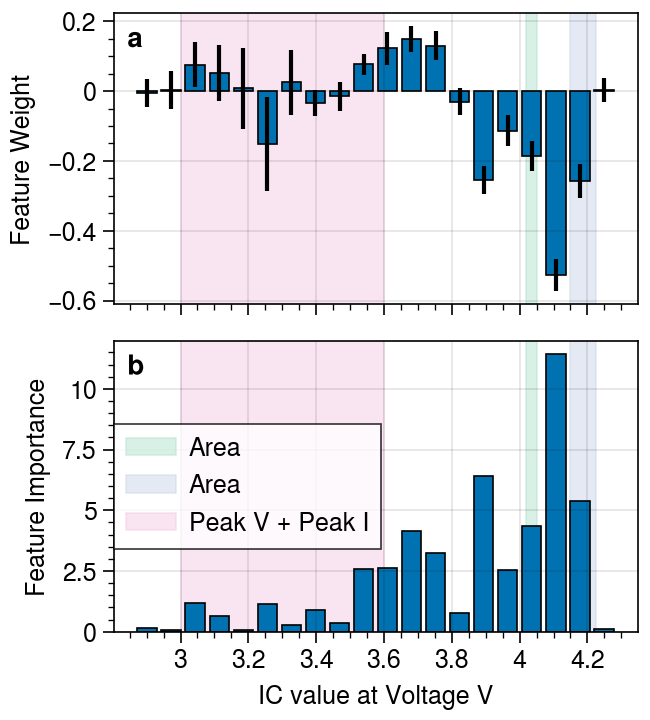

In [39]:
fig,axx = pplt.subplots(nrows=2,ncols=1,width=figwidth*1,aspect=1.8,facecolor='w',sharey=False)
material = 'NCA'
xval = all_data[material]['V_discrete'][1:]

mn = 'Linear Regression'
pp='IC'
xlab = pp+' value at Voltage V'

select_experiments = ml_experiments.loc[ml_experiments.material==material].copy()
select_experiments = select_experiments.loc[select_experiments.model_name==mn]
select_experiments = select_experiments.loc[select_experiments.preprocessing==pp]


idx = [np.round(np.linspace(0, len(xval) - 1, n_features)).astype(int)]
xval = xval[idx]

exp_params = dict(select_experiments.iloc[0,:4])
exp = get_ml_exp(**exp_params)

axx.format(xlabel=xlab,abc=True,abcloc='ul',xlocator=('maxn', 10),ylocator=('maxn', 5))

foi_df = FOIs[material]
SE = calc_std_errors(material,pp,mn)

# for j,p in enumerate(pathinfo.columns[:3]):
ax = axx[0]
j,p=1,'LAMPE'

importance = exp.coef[j]
importance = importance #/np.abs(importance).max()

ax.bar(xval, importance,label=None,yerr=SE.iloc[1:,j])
#     ax.bar(xval, np.abs(importance/SE.iloc[1:,j]),label=None)
# ax.format(lltitle=p)

plot_these_fois = [k for k in foi_df.index if p in foi_df.loc[k,'mode']]
ax = plot_FOI_windows(foi_df.loc[plot_these_fois,:],ax)
ax.set_ylabel('Feature Weight')
h, l = ax.get_legend_handles_labels()

ax = axx[1]
ax.bar(xval, np.abs(importance/SE.iloc[1:,j]),label=None)
ax.set_ylabel('Feature Importance')

ax = plot_FOI_windows(foi_df.loc[plot_these_fois,:],ax)#,ybounds=[-1.1,1.1])

ax.legend(h, l,loc='cl',ncol=1,frameon=True)

# fig.savefig('figures/linreg_interpretation.png',dpi=300,transparent=True)
fig

## Random Forrest Regression

<ipython-input-42-6ae23f241583>:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  xval = xval[idx]
<ipython-input-42-6ae23f241583>:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  xval = xval[idx]
<ipython-input-42-6ae23f241583>:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  xval = xval[idx]


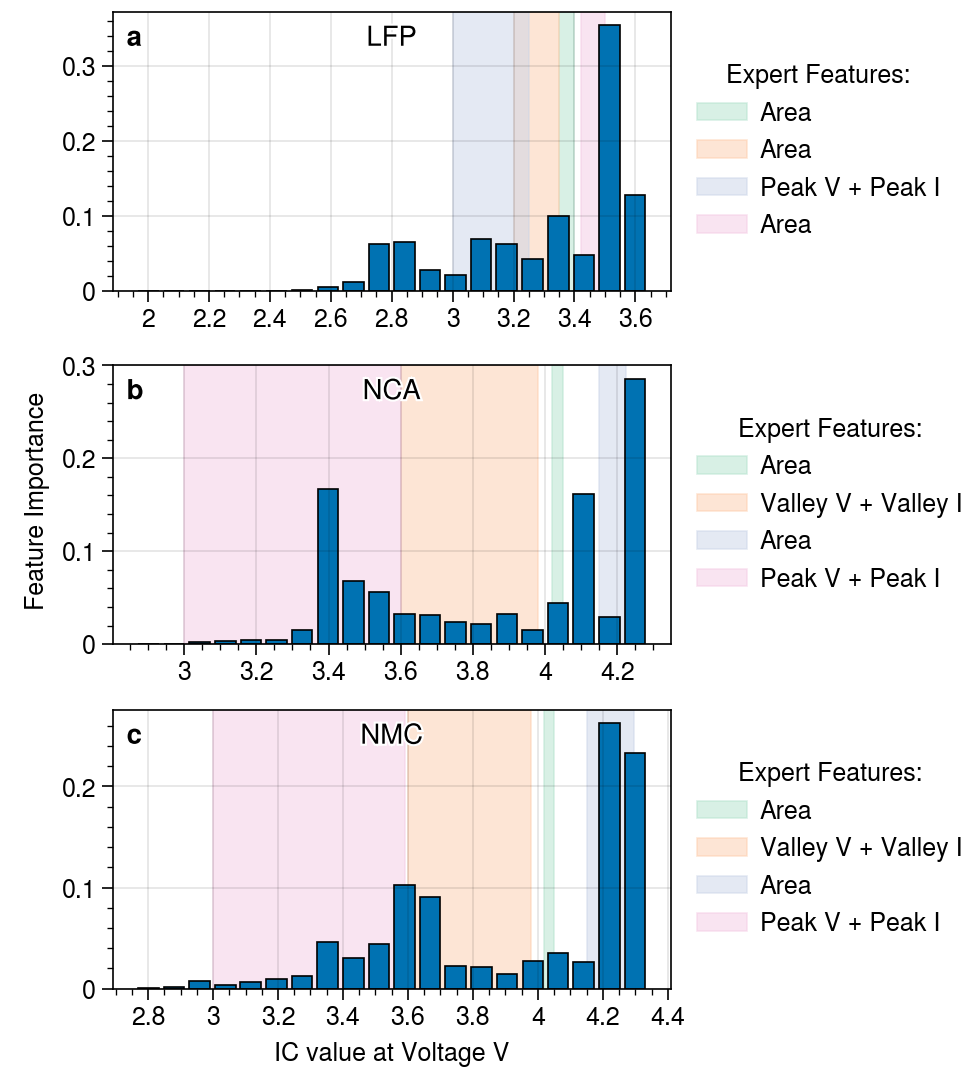

In [42]:
fig,axs = pplt.subplots(nrows=3,ncols=1,sharex=True,width=figwidth*1.5,aspect=2,facecolor='w')

mn = 'Random Forrest Regressor'
pp='IC'
xlab = pp+' value at Voltage V'

for material,ax in zip(['LFP','NCA','NMC'],axs):

    xval = all_data[material]['V_discrete'][1:]

    select_experiments = ml_experiments.loc[ml_experiments.material==material].copy()
    select_experiments = select_experiments.loc[select_experiments.model_name==mn]
    select_experiments = select_experiments.loc[select_experiments.preprocessing==pp]

    idx = [np.round(np.linspace(0, len(xval) - 1, n_features)).astype(int)]
    xval = xval[idx]

    exp_params = dict(select_experiments.iloc[0,:4])
    exp = get_ml_exp(**exp_params)

    ax.format(uctitle=material) #title=preprocessing_label_dict[pp],

    importance = exp.coef
    importance = importance #/np.abs(importance).max()
    ax.bar(xval, importance,label=None)#,'-',label=model_label_dict[mn],alpha=0.5)
    
    ax = plot_FOI_windows(FOIs[material],ax)
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, l,loc='r',ncol=1,frameon=False,title='Expert Features:')

    
axs.format(xlabel=xlab,ylabel='Feature Importance',xlocator=('maxn', 10),abc=True,abcloc='ul') #,rlabels=['LFP','NCA','NMC']

## Logistic Regression
Use statsmodels instead of sklearn to get standard errors for weights, since sklearn doesn't do this. Statsmodels and sklearn give similar trained models.

In [43]:
import statsmodels.api as sm

In [44]:
def calc_std_errors_logreg(material,pp,mn='Logistic Regression'):
    mat_data = all_data[material]
    X_train = mat_data['rescaled_profiles'][pp]['X_train']
    
    coefs,ses = {},{}
    for p in ['PElim','plating']:
        y_train = mat_data['y_train'][p].values

        results = sm.Logit(y_train, X_train).fit()
        ses[p] = np.diagonal(results._results.normalized_cov_params)
        coefs[p] = results._results.params
        
    return pd.DataFrame(coefs),pd.DataFrame(ses)

<ipython-input-45-66ac788dc5f1>:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  xval = xval[idx]


Optimization terminated successfully.
         Current function value: 0.290026
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.217766
         Iterations 10


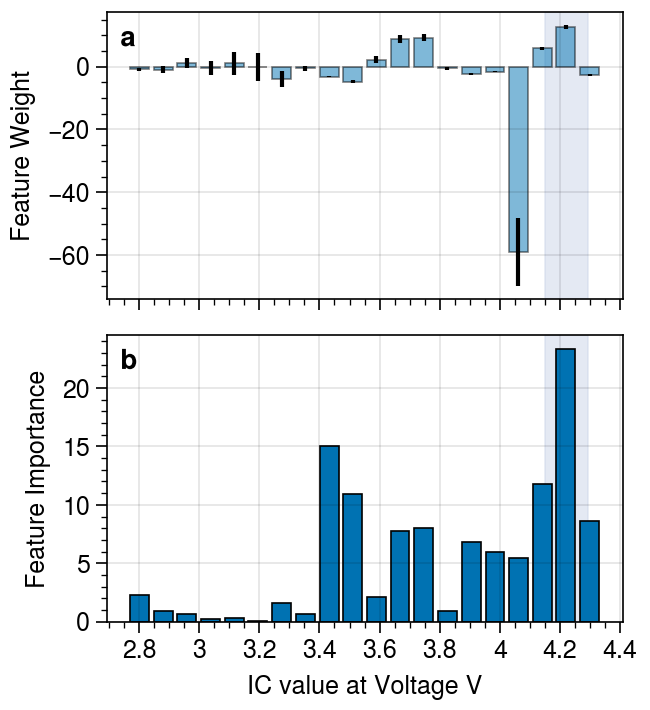

In [45]:
fig,axx = pplt.subplots(nrows=2,ncols=1,width=figwidth,aspect=1.8,facecolor='w',sharey=False)
material = 'NMC'
xval = all_data[material]['V_discrete'][1:]

mn = 'Logistic Regression'
pp='IC'
xlab = pp+' value at Voltage V'

select_experiments = ml_experiments.loc[ml_experiments.material==material].copy()
select_experiments = select_experiments.loc[select_experiments.model_name==mn]
select_experiments = select_experiments.loc[select_experiments.preprocessing==pp]


idx = [np.round(np.linspace(0, len(xval) - 1, n_features)).astype(int)]
xval = xval[idx]

exp_params = dict(select_experiments.iloc[0,:4])
exp = get_ml_exp(**exp_params)

axx.format(xlabel=xlab,abc=True,abcloc='ul',xlocator=('maxn', 10),ylocator=('maxn', 5))

foi_df = FOIs[material]
beta0,SE = calc_std_errors_logreg(material,pp,mn)

j,p = 1,'plating'
ax = axx[0]

importance = exp.coef[j]
importance = importance #/np.abs(importance).max()

ax.bar(xval, beta0.iloc[:,j],label=None,yerr=SE.iloc[:,j],alpha=0.5)

plot_these_fois = [k for k in foi_df.index if 'plating' in foi_df.loc[k,'mode']]
ax = plot_FOI_windows(foi_df.loc[plot_these_fois,:],ax)
ax.set_ylabel('Feature Weight')
h, l = ax.get_legend_handles_labels()

ax = axx[1]
ax.bar(xval, np.abs(beta0.iloc[:,j]/SE.iloc[:,j]),label=None)
ax.set_ylabel('Feature Importance')

ax = plot_FOI_windows(foi_df.loc[plot_these_fois,:],ax)#,ybounds=[-1.1,1.1])

# fig.savefig('figures/logreg_interpretation.png',dpi=300,transparent=True)
fig